### Student ID : 18195121
### Name: Vipul Popat


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.utils import shuffle
import math
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
import pandas as pd

import seaborn as sns

# Task 1

In [2]:
df = pd.read_csv("bank_et1.csv",index_col=['Unnamed: 0'])


In [3]:
df.head(5)

,age,job,marital,education,default,balance,ratio_bal_ln,ratio_ln_inc,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,32,technician,single,tertiary,no,392,1.300134,0.473895,yes,no,cellular,1,apr,957,2,131,2,failure,no
1,39,technician,divorced,secondary,no,688,-0.193701,0.237021,yes,yes,cellular,1,apr,233,2,133,1,failure,no
2,59,retired,married,secondary,no,1035,1.334266,0.121981,yes,yes,cellular,1,apr,126,2,239,1,failure,no
3,47,blue-collar,married,secondary,no,398,0.362286,1.251328,yes,yes,cellular,1,apr,274,1,238,2,failure,no
4,54,retired,married,secondary,no,1004,0.072075,-0.533738,yes,no,cellular,1,apr,479,1,307,1,failure,no


Suggestion: try PLA on this dataset before using the bank dataset

In [4]:
df.tail(5)

,age,job,marital,education,default,balance,ratio_bal_ln,ratio_ln_inc,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
1995,20,student,single,NaN,no,2785,-2.170524,1.081071,no,no,cellular,16,sep,327,2,-1,0,NaN,yes
1996,28,admin.,single,secondary,no,127,0.811788,1.134496,no,no,cellular,16,sep,1334,2,-1,0,NaN,yes
1997,81,retired,married,primary,no,1154,0.504655,0.042190,no,no,telephone,17,sep,231,1,-1,0,NaN,yes
1998,46,services,married,primary,no,4343,-0.965874,0.302708,yes,no,NaN,20,sep,185,1,-1,0,NaN,yes
1999,40,entrepreneur,married,secondary,no,6403,-0.800893,1.066659,no,no,cellular,22,sep,208,2,-1,0,NaN,yes


In [5]:
df.describe()

,age,balance,ratio_bal_ln,ratio_ln_inc,day,duration,campaign,pdays,previous
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,41.751500,1413.663500,0.241951,0.485030,13.851500,292.020500,1.909500,167.896000,2.561500
std,12.723077,3131.224213,0.821604,1.075543,9.712189,221.557295,1.378862,131.754126,3.400735
min,18.000000,-980.000000,-2.632068,-2.851405,1.000000,7.000000,1.000000,-1.000000,0.000000
25%,32.000000,201.500000,-0.308018,-0.274181,5.000000,146.000000,1.000000,75.750000,1.000000
50%,38.000000,551.000000,0.224099,0.487082,12.000000,236.000000,1.000000,182.000000,2.000000
75%,50.000000,1644.500000,0.806315,1.211896,23.000000,379.000000,2.000000,251.000000,3.000000
max,93.000000,81204.000000,2.961979,4.046914,31.000000,1823.000000,11.000000,854.000000,55.000000


In [6]:
nunique = df.nunique()
nunique


age               68
job               11
marital            3
education          3
default            2
balance         1274
ratio_bal_ln    2000
ratio_ln_inc    2000
housing            2
loan               2
contact            2
day               31
month             12
duration         655
campaign          11
pdays            363
previous          26
poutcome           3
subscribed         2
dtype: int64

### The attribute that can be the target/dependable varibale for 2-class classification is "subscribed" which means whether the customer is subscribed for term deposit. This would allow bank to market the product to new customers based for term deposit products

# Task 2

In [7]:
df.isnull().sum() #Check for null values in field

age               0
job              10
marital           0
education       104
default           0
balance           0
ratio_bal_ln      0
ratio_ln_inc      0
housing           0
loan              0
contact         191
day               0
month             0
duration          0
campaign          0
pdays             0
previous          0
poutcome        454
subscribed        0
dtype: int64

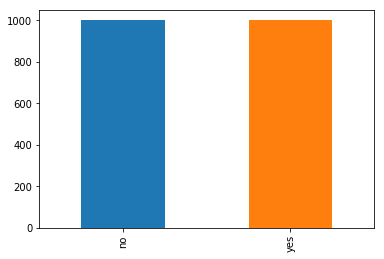

In [8]:
df['subscribed'].value_counts().plot.bar()

### There is a very equal distribution of subscribed data across the samples and this would be the prime candidate for  target/dependable varibale for 2-class classification

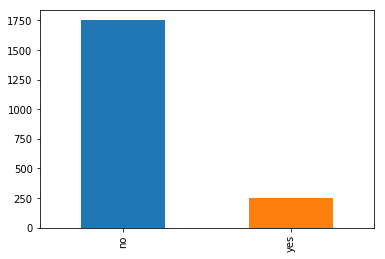

In [9]:
df['loan'].value_counts().plot.bar()

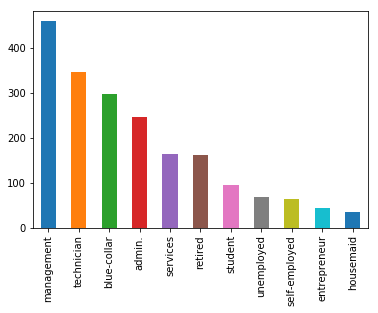

In [10]:
df['job'].value_counts().plot.bar()

### Management represents the highest job category before technician. There are around 10 samples which do not have any job classification which must be corresponding to the missing categories for e.g. engineers, teachers etc or they must have been bundled into the wrong category.


## Use at least two different plotting techniques to plot the distribution of two numerical and two categorical attributes

### Numerical Attributes

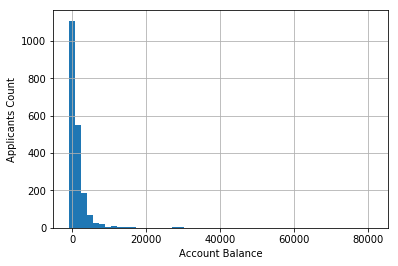

In [11]:
df['balance'].hist(bins=50)
plt.xlabel('Account Balance')
plt.ylabel('Applicants Count')
plt.show()

In the histogram above,

* The fraction of customers which has the highest total balance is in the range of 0 to 10000. 
* 86 customers have 0 balance in the bank
* There is only 1 customer with a balance of > 4000.

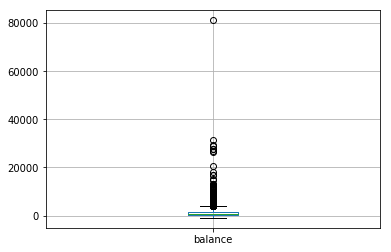

In [12]:
df.boxplot(column='balance')

### The box plot shows that we should be considering the data for balance under 40000 for EDA as there is only one data point > 40000 and that can be considered as an outlier. This should be removed from test training data if we are going to use that feature for the learning process

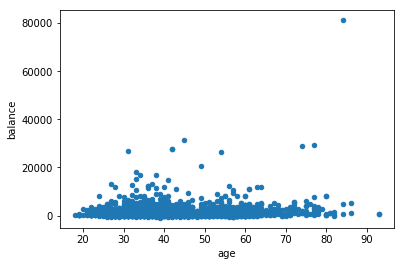

In [13]:
df.plot.scatter(x='age', y='balance')

### Based on this scatter plot we can say that we cannot get a logical or linear separation using these two attributes and it would not allow us to separate the yes and no subscribed as the distribution is overlapping

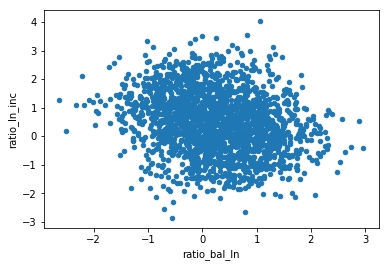

In [14]:
df.plot.scatter(x='ratio_bal_ln', y='ratio_ln_inc')

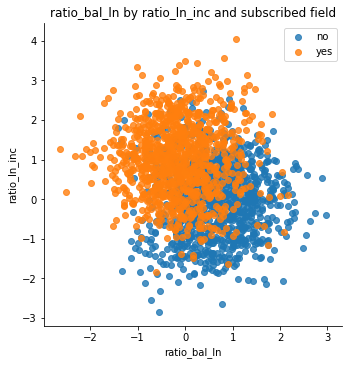

In [15]:
# Ratio_bal_ln by Ratio_ln_inc and Subscribed field
sns.lmplot( x="ratio_bal_ln", y="ratio_ln_inc", data=df, fit_reg=False, hue='subscribed', legend=False)
 
# Legend and title
ax = plt.gca()
ax.set_title("ratio_bal_ln by ratio_ln_inc and subscribed field")
plt.legend(loc='upper right')

### Based on this scatter plot and lmplot, we can say that we could get a linear separation using these two attributes. There is an overlap between the two clusters and hence learning would be difficult. These two also could be said to be the most important features based upon the learning and decision making process for identifying if the user has subscribed to a term deposit or not.

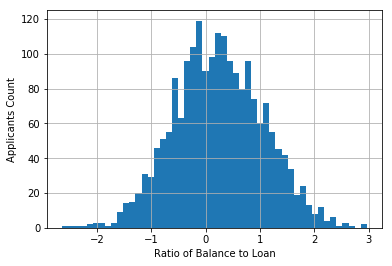

In [16]:
df['ratio_bal_ln'].hist(bins=50)
plt.xlabel('Ratio of Balance to Loan')
plt.ylabel('Applicants Count')
plt.show()

### Looks like this plot signifies a gaussian distribution of this feature

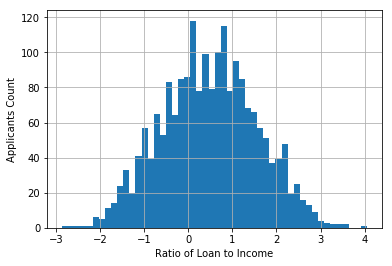

In [17]:
df['ratio_ln_inc'].hist(bins=50)
plt.xlabel('Ratio of Loan to Income')
plt.ylabel('Applicants Count')
plt.show()

### Looks like this plot signifies a gaussian distribution of this feature

### Categorical Attributes

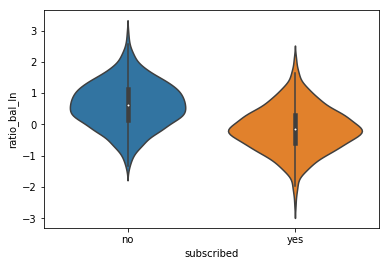

In [18]:
sns.violinplot(x='subscribed', y='ratio_bal_ln',data=df)
plt.show()

### The distribution of ratio of balance to loan and probablity density is quite evenly spread across the no and yes values

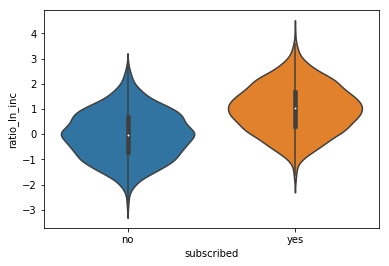

In [19]:
sns.violinplot(x='subscribed', y='ratio_ln_inc',data=df)
plt.show()

### The distribution of ratio of loan to income and probablity density is quite evenly spread across the no and yes values

First, let's take a look at the frequency table for attribute `loan`:

In [20]:
frequency_table = df['loan'].value_counts(ascending=True)
print('Frequency Table for Personal Loan:') 
print(frequency_table)

Frequency Table for Personal Loan:
yes     250
no     1750
Name: loan, dtype: int64


Now we build an Excel-style pivot table for `subscribed` and `loan` with the pivot_table method:

In [21]:
pivot_table = df.pivot_table(values='subscribed',
                       index=['loan'],
                       aggfunc=lambda x: x.map({'yes':1, 'no':0}).mean()) 

In [22]:
print(pivot_table)

      subscribed
loan            
no      0.546857
yes     0.172000


Hence the probabilty of applicant with no personal loan subscribing to term deposit is 54% compared to application with a personal loan which is just 17%

Let's plot `loan` and the probability of subscribing to term deposit based on `loan`

Text(0.5, 1.0, 'Applicants by Personal Loan')

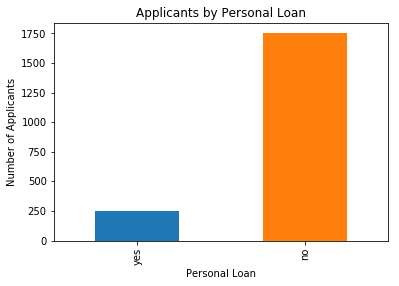

In [23]:
# Plot the frequency table for Credit_History
frequency_table.plot(kind='bar')
plt.xlabel('Personal Loan')
plt.ylabel('Number of Applicants')
plt.title('Applicants by Personal Loan')

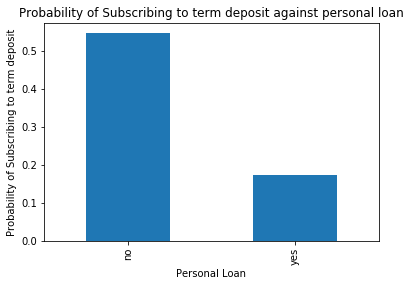

In [24]:
# Plot pivot table
pivot_table.plot(kind='bar')
plt.xlabel('Personal Loan')
plt.ylabel('Probability of Subscribing to term deposit')
plt.title('Probability of Subscribing to term deposit against personal loan')
plt.legend().set_visible(False) # we don't need the default legend

# Task 3

The dataset provided in the task consists of 2000 samples which correspond to historical records regarding a marketing campaign.

We are trying to extract a two dimensional **input space** that can be utilized to predict the **output space** which refers to whether the customer has already subscribed to a term deposit product or not.

The two inputs selected on the decision making process above are
- balance / loan ratio
- loan / income ratio

These two attributes will be used to learn and identify a **unknown target function** which links to the above mentioned input and output spaces. Our objective is to use the perceptron algorithm to determine the **hypothesis set**. Out of the probable candidates of the hypothesis set, we would need to determine the best suited one for the problem which would be the **final hypothesis**.

On Execution of PLA on the dataset, there is a need to compare **in-sample error** and the **out-sample** error against the Hoeffding bound and determine if learning is indeed possible.


# Task 4

In [25]:
# introudced the random state so that we always get the same results and consistent dataset
X, y = make_blobs(n_samples=1000, centers=2, n_features=2,random_state=42)
y = [yy if yy == 1 else -1 for yy in y]


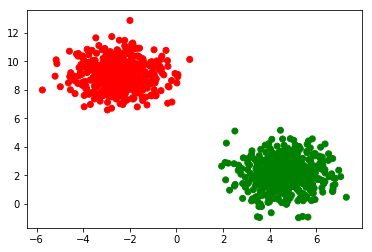

In [26]:
colors = ['green' if yy == 1 else 'red' for yy in y] 
plt.scatter(X[:,0],X[:,1], color=colors)
plt.show()

In [27]:
def h(x,w):
    #Perceptron model: the sign of the dot product of weights and input vector determines the class allocation
    bias = np.array([1])
    return np.sign(w.T.dot(np.concatenate((bias,x))))

In [28]:
def point_on_boundary(weights, x):
    # Return the y-position on the boundary based on given x-position
    return -(weights[0]+weights[1]*x)/weights[2]

In [29]:
def decision_boundary(weights, x_min, x_max):
    # Return two points on the decision boundary
    # changed the below function based on pep's and others recommendations as it was a bug
    return [point_on_boundary(weights, x_min), point_on_boundary(weights, x_max)]

In [30]:
def pla(training_in, training_out, weights, max_iterations=1000):
    bias = np.array([1])
    iterations=0
    while True:
        errors = 0;
        for x,y in zip(training_in, training_out):
            if (h(x,weights)!=y):
                iterations+=1;
                weights = weights + y*(np.concatenate((bias,x)))
                errors+=1;
        if (errors == 0):
            print("Hypothesis(g) found after ",iterations, " iterations")
            break
            
    return weights, iterations

In [31]:
def calc_error(training_in, training_out, weights):
    # Calculate the classification error as the fraction of training samples that are misclassified
    errors=0
    for x,y in zip(training_in, training_out):
        if (h(x,weights)!=y):
            errors+=1;
    return errors/len(training_in)

In [32]:
def exec_pla(X,y,w):
    #w = np.array([0,0,0])
    # setting the first weight which is the bias to 1
    w[0] = 1
    
    w,n_iterations = pla(X,y,w)
    xs = [X[:,0].min(),X[:,0].max()]
    ys = decision_boundary(w,xs[0],xs[1])
    # plotting the decision boundary
    colors = ['green' if yy == 1 else 'red' for yy in y] 
    plt.scatter(X[:,0],X[:,1], color=colors)
    plt.plot(xs,ys, 'b-')
    plt.title("Iteration: {:.0f} : Bias = {}, weight1 = {:.2f}, weight2 = {:.2f}".format(n_iterations,w[0],w[1],w[2]))
    plt.show()

Hypothesis(g) found after  2  iterations


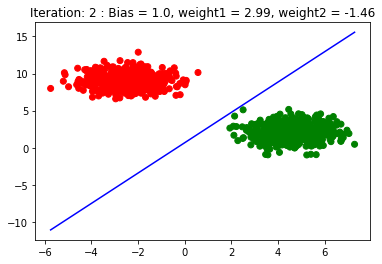

In [33]:
exec_pla(X,y, np.array([0,-5,5]))

Hypothesis(g) found after  23  iterations


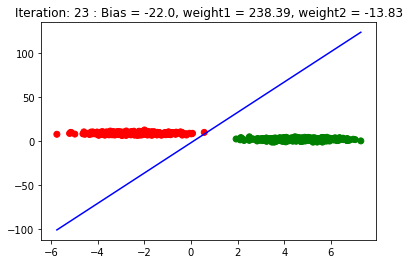

In [34]:
exec_pla(X,y, np.array([0,200,200]))

Hypothesis(g) found after  3  iterations


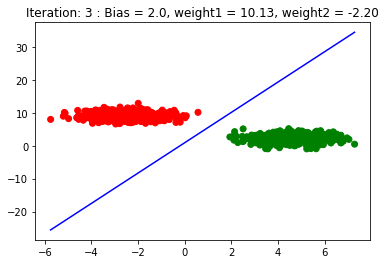

In [35]:
exec_pla(X,y,np.array([10,0.000001,0.00000001]))

In [36]:
# Start by converting "subscribed" target from "yes/no" to "1/-1"
df['subscribed_code'] = df['subscribed'].map({'yes': 1, 'no': -1})
df[["subscribed", "subscribed_code"]].head(5)

,subscribed,subscribed_code
0,no,-1
1,no,-1
2,no,-1
3,no,-1
4,no,-1


### Improving the PLA and applying the PLA to banking data, we are taking a split of train/test data of 80-20 percent

## The PLA can be improved using two methods
- Pocketing the weights and errors whenver the new error calculated is small than the previous error

In [37]:
def pla_pocket(training_in, training_out, test_in, test_out, weights, max_iterations):
    bias = np.array([1])
    iterations = 0
    
    err_vals = np.zeros((training_in.shape[0]*max_iterations+1,2))
    
    e_in = calc_error(training_in, training_out, weights)
    e_out = calc_error(test_in, test_out, weights)
    err_vals[0] = [e_in,e_out]  
    k = 1
    while iterations < max_iterations:
        errors = 0
        iterations +=1
        print("Iteration:{}/{}".format(iterations, max_iterations))        
        for x,y in zip(training_in, training_out):
            if (h(x,weights)!=y):
                # if the new error calculated is bette than the previous error
                # the the new weights and error would be pocketed 
                new_weights = weights + y*(np.concatenate((bias,x)))
                errors+=1
                new_e_in = calc_error(training_in, training_out, new_weights)
                
                if (new_e_in < e_in):
                    e_in = new_e_in
                    weights = new_weights
                    e_out = calc_error(test_in, test_out, weights)
                    print("Pocketing weights:{} error:{} at Iteration {}".format(weights, new_e_in, iterations))
            err_vals[k] = [e_in,e_out] 
            k+=1;
            
        if (errors == 0):
            print("Hypothesis found. number of iterations:", iterations)
            break

    return err_vals,weights

In [38]:
from sklearn.model_selection import train_test_split
import random

def random_weights(): 
     # Initiatialing the weights with random values
     return np.array([random.uniform(0, 1),random.uniform(0, 1),random.uniform(0, 1)])

# Use 'ratio_bal_ln' and 'ratio_ln_inc' as our inputs
data = df[['ratio_bal_ln', 'ratio_ln_inc', 'subscribed_code']]
# Use 'ratio_bal_ln' and 'ratio_ln_inc' as our inputs
X = data[['ratio_bal_ln', 'ratio_ln_inc']].values

# Use 'subscribed_code' as the target
y = data['subscribed_code'].values

#choose randomly 20% of zeros as testing while the rest goes for training
train, test = train_test_split(data, test_size=0.2, shuffle=True)

X_train_data = train[['ratio_bal_ln','ratio_ln_inc']].values
y_train_data = train[['subscribed_code']].values
X_test_data = test[['ratio_bal_ln','ratio_ln_inc']].values
y_test_data = test[['subscribed_code']].values


### The decision boundry is far better than the earlier one. It wont be able to divide it fully as we knew in the first place that there was an overlap in the distribution

Iteration:1/10
Pocketing weights:[1.01666938 0.64212253 0.08575161] error:0.503125 at Iteration 1
Pocketing weights:[ 0.01666938 -0.0827046   1.10059745] error:0.308125 at Iteration 1
Pocketing weights:[-0.98333062 -1.46722177  0.99887505] error:0.25875 at Iteration 1
Pocketing weights:[ 0.01666938 -1.53117811  0.52517422] error:0.235 at Iteration 1
Iteration:2/10
Iteration:3/10
Iteration:4/10
Iteration:5/10
Iteration:6/10
Iteration:7/10
Iteration:8/10
Iteration:9/10
Iteration:10/10
Min E_in = 0.235, Min E_out = 0.25


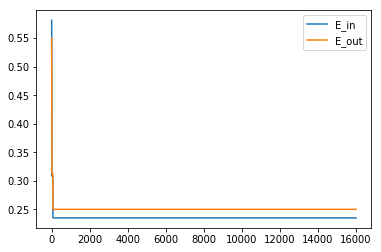

In [39]:
# execution of test and train dataset on pocket pla algorithm.
error_vals,weights = pla_pocket(X_train_data, y_train_data, X_test_data, y_test_data, random_weights(), 10)
print("Min E_in = {}, Min E_out = {}".format(np.min(error_vals[:,0]), np.min(error_vals[:,1])))
plt.plot(np.arange(error_vals.shape[0]), error_vals[:,0],error_vals[:,1])
plt.legend(['E_in','E_out'])
plt.show()

It is also noticeable from the plot above that the E_in and E_out **follow the same trajectory** which would concur that the model in predictions would not deviate much from the train dataset

**the error rate on the testing data set more or less matches the training dataset**. Despite the overlap of the between the two data points, its proven that Pocket algorithm still tries to learn with a equivalent error rate in test and training samples

We were able to see that **Eout tracks Ein very closely which is one of the conditions of learning.**

## Plotting the decision boundary in the bank dataset to separate the clusters

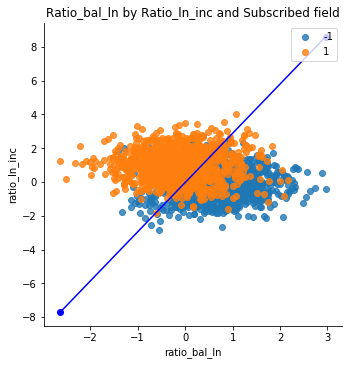

In [40]:
sns.lmplot( x="ratio_bal_ln", y="ratio_ln_inc", data=data, fit_reg=False, hue='subscribed_code', legend=False)
ax = plt.gca()
ax.set_title("Ratio_bal_ln by Ratio_ln_inc and Subscribed field")
plt.legend(loc='upper right')

# Plot the decision boundary line
x_min = min(X[:,0])
x_max = max(X[:,0])
y_min, y_max = decision_boundary(weights, x_min, x_max)

plt.plot([x_min, x_max], [y_min, y_max], 'bo-')
plt.show()

### It is noticeable from the decision boundary above that the clusters are not linearly separable. The model trainied with weights is the best it can to linearly separate the two data points

### In order to plot the Hoeffding bound, we would need to run the pocket algorithm multiple times (aka number of bins or hypothesis which is M)

In [41]:
M=10
E_in_array = []
E_out_array = []

for m in range(M):

    print("=="*50)
    print("Hypothesis #:{}".format(m+1))
    
    train, test = train_test_split(data, test_size=0.2, shuffle=True)

    X_train_data = train[['ratio_bal_ln','ratio_ln_inc']].values
    y_train_data = train[['subscribed_code']].values
    X_test_data = test[['ratio_bal_ln','ratio_ln_inc']].values
    y_test_data = test[['subscribed_code']].values

    error_vals_res,weights_res = pla_pocket(X_train_data, y_train_data, X_test_data, y_test_data, random_weights(), 10)
    E_in_array.append(np.min(error_vals_res[:,0]))
    E_out_array.append(np.min(error_vals_res[:,1]))

print("E_in_array:", E_in_array)
print("E_out_array:", E_out_array)

Hypothesis #:1
Iteration:1/10
Pocketing weights:[-0.59251908 -0.2336271   0.78035353] error:0.27625 at Iteration 1
Pocketing weights:[ 0.40748092 -1.04122758  0.72853971] error:0.25 at Iteration 1
Pocketing weights:[-0.59251908 -0.77245327  1.35891306] error:0.240625 at Iteration 1
Pocketing weights:[ 0.40748092 -1.43642285  1.30763875] error:0.24 at Iteration 1
Pocketing weights:[-0.59251908 -1.16731472  1.89721047] error:0.2375 at Iteration 1
Pocketing weights:[ 0.40748092 -1.67981011  1.38190034] error:0.236875 at Iteration 1
Pocketing weights:[-0.59251908 -1.83435057  1.05976164] error:0.23375 at Iteration 1
Pocketing weights:[ 0.40748092 -1.60688595  1.03197123] error:0.2275 at Iteration 1
Pocketing weights:[-0.59251908 -1.54432533  1.21408292] error:0.221875 at Iteration 1
Iteration:2/10
Iteration:3/10
Iteration:4/10
Iteration:5/10
Iteration:6/10
Iteration:7/10
Iteration:8/10
Iteration:9/10
Iteration:10/10
Hypothesis #:2
Iteration:1/10
Pocketing weights:[1.02411044 0.07078624 3.0

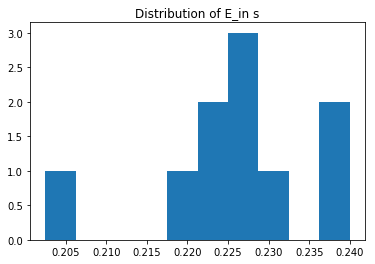

In [42]:
plt.hist(E_in_array)
plt.title('Distribution of E_in s')
plt.show()

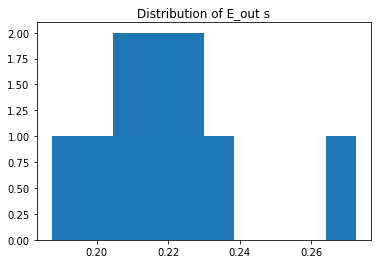

In [43]:
plt.hist(E_out_array)
plt.title('Distribution of E_out s')
plt.show()

Epsilon probability Distribution: [1.0, 0.6, 0.4, 0.3, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
M (Number of Hypothesis): 10
N (Number of samples): 2000


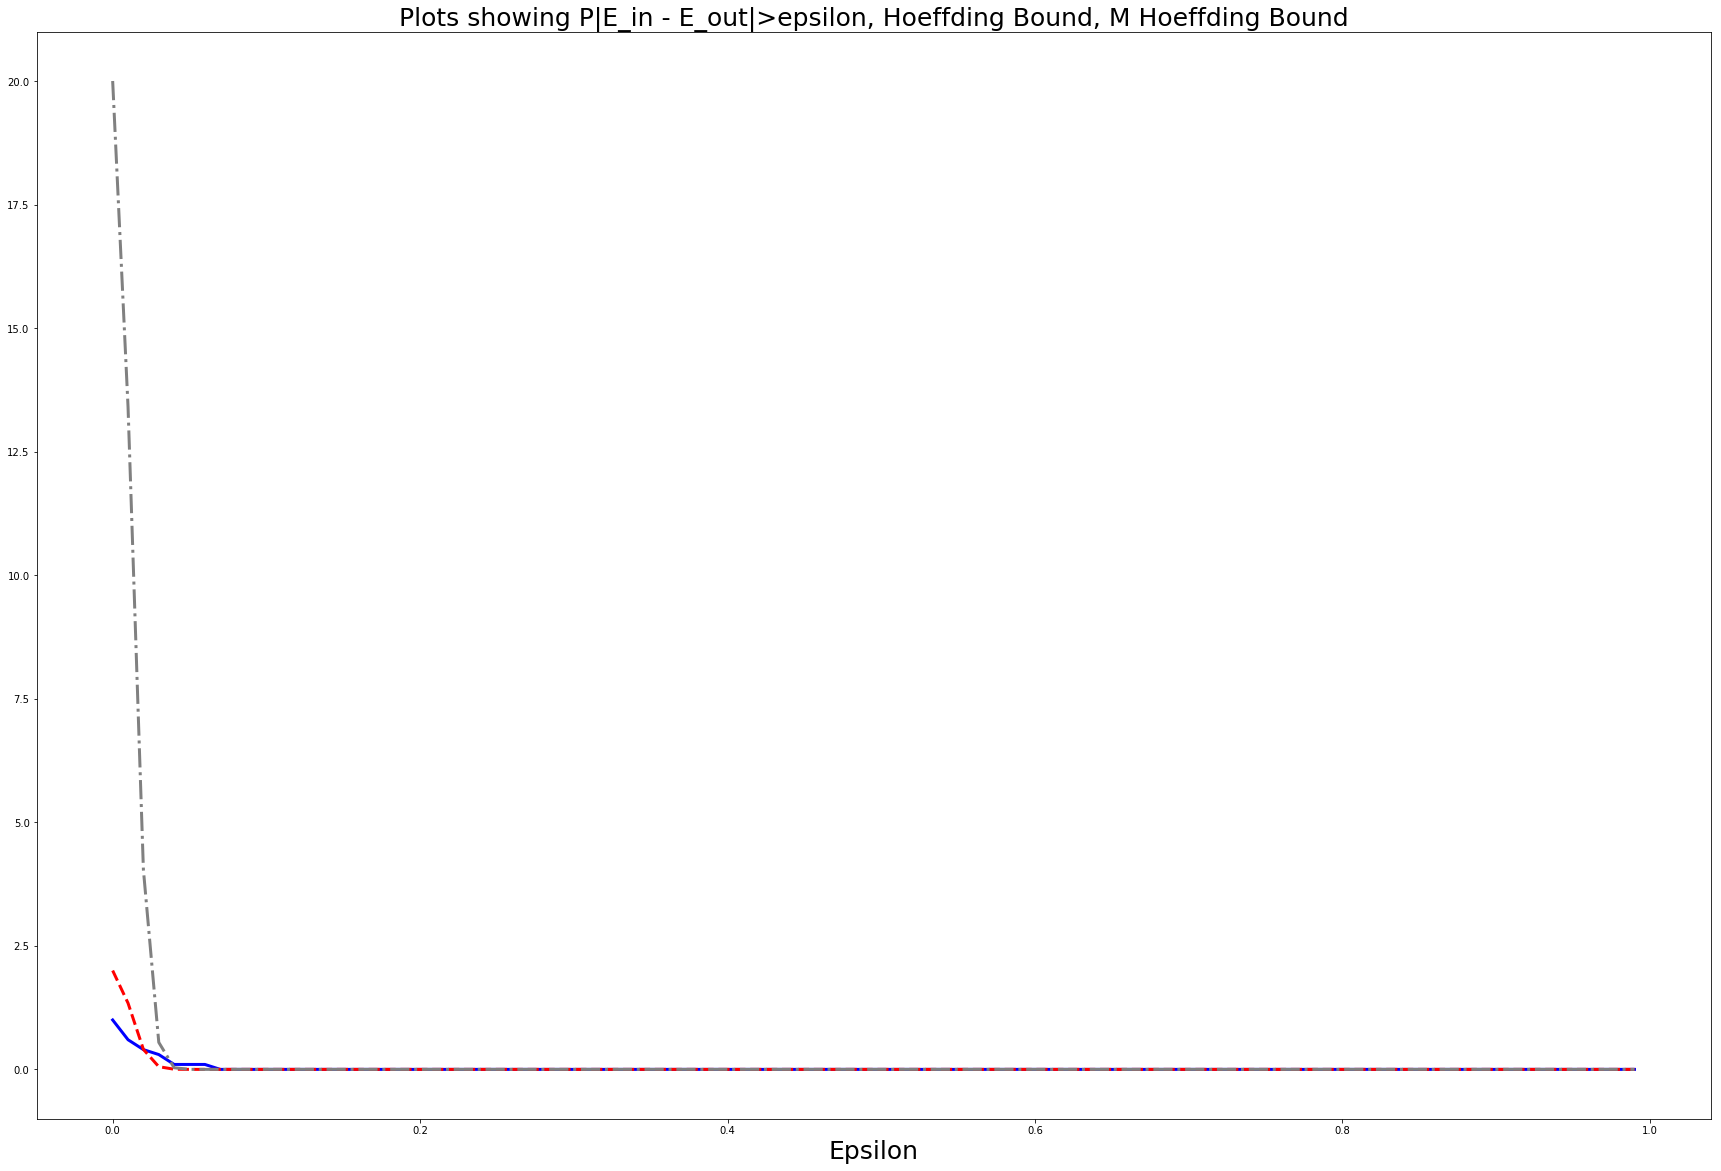

In [44]:
# Calculate probabily of epsilon
prob_epsilon=[]
epsilons = np.arange(0, 1, 0.01)

for e in epsilons:   
    counter = 0
    for i in range(M):
        if abs(E_in_array[i] - E_out_array[i])>e:
               counter +=1
    prob_epsilon.append(counter/M)           

N = len(X)

plt.figure(figsize=(30,20))
plt.plot(epsilons, prob_epsilon, color='blue', linewidth=3)
plt.plot(epsilons, [2*math.exp(-2*e**2*N) for e in epsilons], color='red',linestyle='--', linewidth=3)
plt.plot(epsilons, [2*M*math.exp(-2*e**2*N) for e in epsilons], color='grey', linestyle='-.', linewidth=3)
plt.title("Plots showing P|E_in - E_out|>epsilon, Hoeffding Bound, M Hoeffding Bound",fontsize=25)
plt.xlabel("Epsilon",fontsize=25)
plt.show

print("Epsilon probability Distribution:", prob_epsilon)
print("M (Number of Hypothesis):", M)
print("N (Number of samples):", N)

The plot above was insipired by **Michel Danjou**'s submission. The way he achieved it was quite easy to understand and hence i tried to understand and follow the same.

**Notes**
  There are 3 lines ploted above.
  * P[|Ein-Eout|]>epsilon
  * Hoeffding bounds (curve with a value of 2 when epsilon is 0)
  * Hoeffding bounds for "multiple hypothesis" (curve with a value of 20 when epsilon is 0)
  
**Observations**  
Looking at the plot above for P(Ein-Eout) line crosses the **the Hoeffding bounds** and hence dosent always remain underneath the hoeffding bounds.

**When epsilon ~ 0**
When epsilon is close to zero, the probability P[|Ein-Eout|]>epsilon is 1 which is understandable.
The Heofdding bound and the M x Heoffding are 2 and 20 respectively, which is correct.

It would be apt to say that the learning using Hoeffding bound would not be applicable to the dataset 

The chosen feature is a simple classification problem with a probability of 50%. The error rate which we have of ~ 23% is a substantial improvement. Hence we can say that **we are learning** but not as much.
